# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import numpy.random as npr

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [3]:
def compute_distance(x: np.ndarray, y: np.ndarray) -> np.ndarray: 
    # TODO: Compute the Euclidean distance from the origin
    distance = np.sqrt( x**2 + y**2 )
    return distance

def fit(distance: np.ndarray, SNR: np.ndarray, degree: int) -> np.ndarray:
    return np.polyfit(distance, SNR, deg=degree)
# p: polinomial coefficients, highest degree first

def predict(distance: np.ndarray, poly_coeffs: np.ndarray) -> np.ndarray:
    # TODO:  Predict the SNR from a given model
    poly_coeffs = poly_coeffs[::-1] # lowest degree first
    SNR_predicted = np.zeros(len(distance))
    for k, coefficient in enumerate(poly_coeffs):
        SNR_predicted += distance**k * coefficient
    return SNR_predicted 

def evaluate(distance: np.ndarray, SNR: np.ndarray, poly_coeffs: np.ndarray) -> np.ndarray:
    # TODO: Compute the error of the polynomial fit on the chosen data
    SNR_predicted = predict(distance, poly_coeffs)
    mse_array = ( SNR_predicted - SNR )**2
    mse = np.mean(mse_array)
    return mse

def separate_test(distance: np.ndarray, SNR: np.ndarray, test_points: int):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly
    indexes = np.arange(0, len(distance))
    test_indexes = np.random.choice(indexes, size= test_points, replace= False)
    train_indexes = np.array( list( set(indexes) - set(test_indexes) ), dtype= int)
    x_train = distance[train_indexes]
    y_train = SNR[train_indexes]
    x_test = distance[test_indexes]
    y_test = SNR[test_indexes]

    return x_train, y_train, x_test, y_test

Text(0, 0.5, 'SNR')

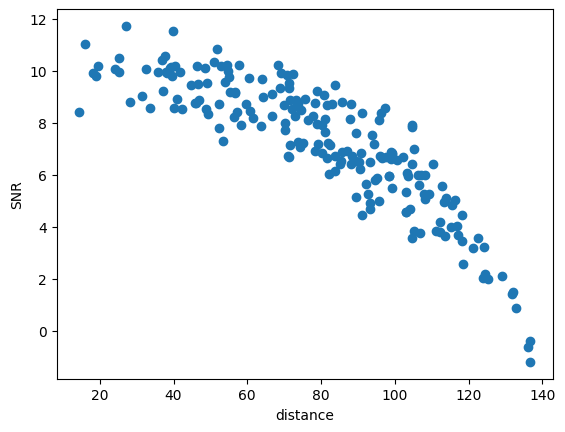

In [4]:
# TODO: separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, int (len(distance)/2 ) )

import matplotlib.pyplot as plt
plt.scatter(distance, SNR)
plt.xlabel("distance")
plt.ylabel("SNR")

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [5]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results(= class scores) for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR
    """
    Returns:
    - best: (np.ndarray) coefficients of the best polynomial
    - results: (np.ndarray) score of each degree subclass, defined as the average validation loss
    """
    idxs = np.arange(0, len(x_train))
    npr.shuffle(idxs)
    folds_idxs = np.array_split( idxs , k)
    

    results = [] #score of each degree subclass

    for degree in range(max_degree + 1):
        fold_results = []
        for i in range(k):
            validation_idxs = folds_idxs[i]

            training_idxs = np.array( list( set(idxs) - set(validation_idxs)) , dtype = int)
            x_validation_fold = x_train[validation_idxs]
            y_validation_fold = y_train[validation_idxs]
            x_train_fold = x_train[training_idxs]
            y_train_fold = y_train[training_idxs]

            poly = fit(distance= x_train_fold, SNR= y_train_fold, degree= degree)
            mse = evaluate(distance= x_validation_fold, SNR= y_validation_fold, poly_coeffs= poly)
            fold_results.append(mse)
        # Compute average validation loss
        results.append(np.mean(fold_results))

    # Find best degree
    best_degree = np.argmin(results)
    # Fit again with that degree, using whole training dataset now
    best = fit(distance= x_train, SNR= y_train, degree= best_degree)

    return best, results

Test error: 1.0733822062179983


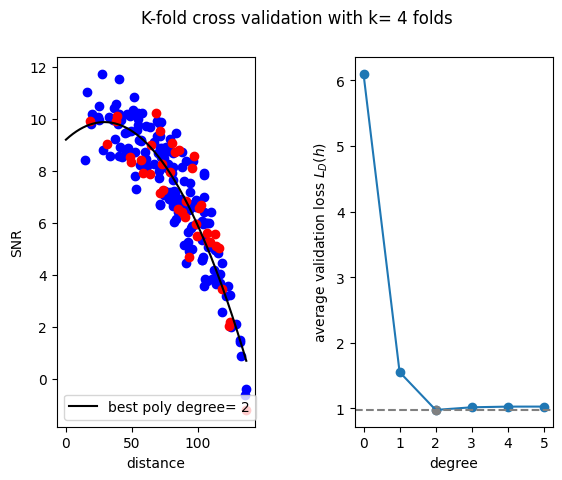

In [6]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree
k = 4


x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points= 40 )
best, results = k_fold_cross_validation(x_train, y_train, k, max_degree= 5)
#print("best degree: \n", len(best) -1, '\n', best, '\n\n')
#print(results)

fig, axs = plt.subplots(nrows= 1, ncols= 2)
plt.suptitle(f"K-fold cross validation with k= {k} folds")
plt.subplots_adjust(wspace= 0.5)
# Best fit plot
axs[0].scatter(x_train, y_train, color = 'blue')
axs[0].scatter(x_test, y_test, color = 'red')
x_fine_spaced = np.linspace(0, np.max(distance), 1000)
y_fine_spaced = predict(x_fine_spaced, best)
axs[0].plot(x_fine_spaced, y_fine_spaced, color = 'black', label= f'best poly degree= {len(best) - 1}')
axs[0].legend(loc= "best")
axs[0].set_xlabel("distance")
axs[0].set_ylabel("SNR")
# Validation loss w.r.t. degree
degrees = np.arange(len(results), dtype= int)
axs[1].scatter(degrees, results)
axs[1].plot(degrees, results)
axs[1].axhline(np.min(results), linestyle = 'dashed', color = 'grey')
axs[1].scatter(degrees[np.argmin(results)], np.min(results), color = 'grey')
axs[1].set_xticks(degrees)
axs[1].set_xticklabels([f"{degree}" for degree in degrees])
axs[1].set_xlabel("degree")
axs[1].set_ylabel(r"average validation loss $L_D(h)$")


test_error = evaluate(x_test, y_test, best)
print("Test error:", test_error)

In [7]:
# TODO: get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

Answer: no, the output changes: the best degree fluctuates between 3 and 5

---

## B. Tikhonov regularization (RLM learning rule)

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [8]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    results = []
    for degree in range(max_degree + 1):
        poly = fit(distance= x_train, SNR= y_train, degree= degree)
        mse = evaluate(distance= x_train, SNR= y_train, poly_coeffs= poly)
        regularized_loss = mse + lambda_par * np.sum( poly**2)
        results.append(regularized_loss)
    # Find best model
    best_degree = np.argmin(results)
    best = fit(distance= x_train, SNR= y_train, degree= best_degree)
    return best, results

Test error: 0.9335117640369359


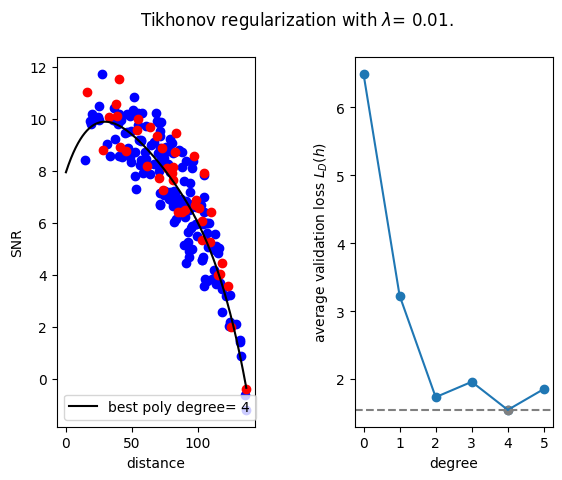

In [9]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree
lambda_par = 0.01

x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points= 40 )
best, results = evaluate_tikhonov(x_train, y_train, lambda_par= lambda_par, max_degree= 5)
#print("best degree: \n", len(best) -1, '\n', best, '\n\n')
#print(results)

fig, axs = plt.subplots(nrows= 1, ncols= 2)
plt.suptitle(fr"Tikhonov regularization with $\lambda$= {lambda_par}.")
plt.subplots_adjust(wspace= 0.5)
# Best fit plot
axs[0].scatter(x_train, y_train, color = 'blue')
axs[0].scatter(x_test, y_test, color = 'red')
x_fine_spaced = np.linspace(0, np.max(distance), 1000)
y_fine_spaced = predict(x_fine_spaced, best)
axs[0].plot(x_fine_spaced, y_fine_spaced, color = 'black', label= f'best poly degree= {len(best) - 1}')
axs[0].legend(loc= "best")
axs[0].set_xlabel("distance")
axs[0].set_ylabel("SNR")
# Validation loss w.r.t. degree
degrees = np.arange(len(results), dtype= int)
axs[1].scatter(degrees, results)
axs[1].plot(degrees, results)
axs[1].axhline(np.min(results), linestyle = 'dashed', color = 'grey')
axs[1].scatter(degrees[np.argmin(results)], np.min(results), color = 'grey')
axs[1].set_xticks(degrees)
axs[1].set_xticklabels([f"{degree}" for degree in degrees])
axs[1].set_xlabel("degree")
axs[1].set_ylabel(r"average validation loss $L_D(h)$")


test_error = evaluate(x_test, y_test, best)
print("Test error:", test_error)

## C. Minimum description length regularization (SRM learning rule)

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [10]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply MDL regularization AFTER the fitting process
    results = []
    for degree in range(max_degree + 1):
        poly = fit(distance= x_train, SNR= y_train, degree= degree)
        mse = evaluate(distance= x_train, SNR= y_train, poly_coeffs= poly)
        regularized_loss = mse + lambda_par * 2**degree
        results.append(regularized_loss)
    # Find best model
    best_degree = np.argmin(results)
    best = fit(distance= x_train, SNR= y_train, degree= best_degree)
    return best, results

Test error: 0.9972427932927858


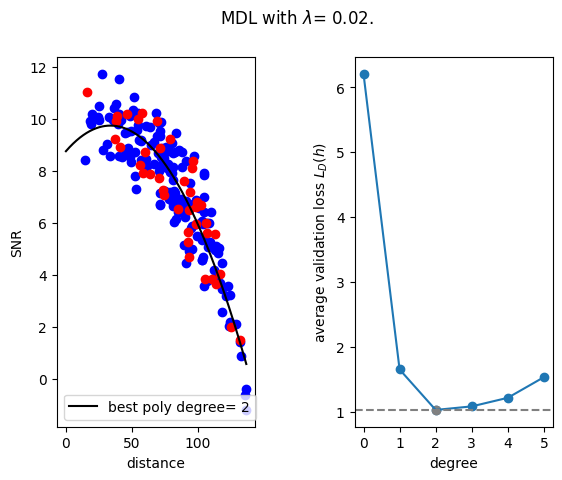

In [11]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree

lambda_par = 0.02

x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points= 40 )
best, results = evaluate_representation(x_train, y_train, lambda_par= lambda_par, max_degree= 5)
#print("best degree: \n", len(best) -1, '\n', best, '\n\n')
#print(results)

fig, axs = plt.subplots(nrows= 1, ncols= 2)
plt.suptitle(fr"MDL with $\lambda$= {lambda_par}.")
plt.subplots_adjust(wspace= 0.5)
# Best fit plot
axs[0].scatter(x_train, y_train, color = 'blue')
axs[0].scatter(x_test, y_test, color = 'red')
x_fine_spaced = np.linspace(0, np.max(distance), 1000)
y_fine_spaced = predict(x_fine_spaced, best)
axs[0].plot(x_fine_spaced, y_fine_spaced, color = 'black', label= f'best poly degree= {len(best) - 1}')
axs[0].legend(loc= "best")
axs[0].set_xlabel("distance")
axs[0].set_ylabel("SNR")
# Validation loss w.r.t. degree
degrees = np.arange(len(results), dtype= int)
axs[1].scatter(degrees, results)
axs[1].plot(degrees, results)
axs[1].axhline(np.min(results), linestyle = 'dashed', color = 'grey')
axs[1].scatter(degrees[np.argmin(results)], np.min(results), color = 'grey')
axs[1].set_xticks(degrees)
axs[1].set_xticklabels([f"{degree}" for degree in degrees])
axs[1].set_xlabel("degree")
axs[1].set_ylabel(r"average validation loss $L_D(h)$")


test_error = evaluate(x_test, y_test, best)
print("Test error:", test_error)

### TEST

Check the performance of the three solutions on the test set: which one does best?


Test empirical losses (mse): [np.float64(0.9771992100275378), np.float64(0.9771992100275378), np.float64(0.9355392932807245)]


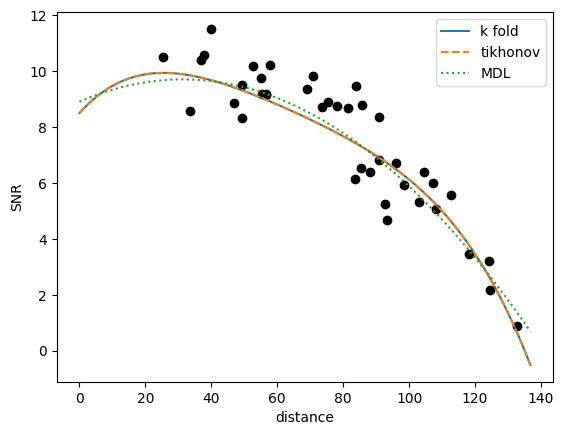

In [40]:
# TODO: plot the results
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points= 40 )
best_kfold, _ = k_fold_cross_validation(x_train, y_train, k= 4, max_degree= 5)
best_tikhonov, _ = evaluate_tikhonov(x_train, y_train, lambda_par= 0.01, max_degree= 5)
best_mdl, _ = evaluate_representation(x_train, y_train, lambda_par= 0.02, max_degree= 5)
best_models = [best_kfold, best_tikhonov, best_mdl]
best_models_labels = ['k fold', 'tikhonov', 'MDL']
test_losses = [evaluate(x_test, y_test, poly_coeffs= best) for best in best_models]
print("Test empirical losses (mse):", test_losses)
lines = ['solid', 'dashed', 'dotted']

fig, ax = plt.subplots()
ax.scatter(x_test, y_test, color = 'black')
x_fine_spaced = np.linspace(0, np.max(distance), 1000)
for i,best in enumerate(best_models):
    y_fine_spaced = predict(x_fine_spaced, best)
    ax.plot(x_fine_spaced, y_fine_spaced, label= best_models_labels[i], linestyle = lines[i])
    ax.legend(loc= "best")
    ax.set_xlabel("distance")
    ax.set_ylabel("SNR")
